In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer 
from qiskit import assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RYGate, HGate
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import arccos, sqrt, log2, ceil, floor

In [2]:
# Open controlled Hadamard gate
def ctrH(ctrl_state='0'): # defines an open control
    ch_gate = HGate().control(1, ctrl_state=ctrl_state) # makes a controlled H gate , 1 means 1 control qubit
    qc = QuantumCircuit(2)
    qc.append(ch_gate, [0, 1])  #here qubit 0 = control, qubit 1 = target
    return qc.to_instruction(label=f"CH(ctrl=|{ctrl_state}⟩)") # here the instructions means converts the entire mini circuit into a single reusable instruction
# behave like a single reusable instruction and is labeling  CH(ctrl=|0⟩) for easy recognition 
# it behaves like a custom gate 

# Open-controlled RY gate
def ctrR(theta, ctrl_state='0'): # open control 
    cry_gate = RYGate(theta).control(1, ctrl_state=ctrl_state) # creates a single qubit Ry rotation gate 
    qc = QuantumCircuit(2)
    qc.append(cry_gate, [0, 1])  # here qubit 0 = control, qubit 1 = target
    return qc.to_instruction(label=f"CRY({theta:.2f})")


In [3]:
def consecutivestates(M):
    n = int(ceil(log2(M))) # returns the smallest integer greater than or equal to the given number
    qc = QuantumCircuit(n) # creates an  n qubit quantum circuit

    binary_str = bin(M)[2:][::-1] # here converting the M into a binary representation and [2:] slices off the '0b' prefix.
    # [::-1]  reverses the string since in quantum circuit representation its reverse of binary representation
    positions = [i for i, bit in enumerate(binary_str) if bit == '1']
    # here checking which qubit position is 1 and select only those qubits enumerate helps to identify at which position which qubit is there 
    k = len(positions) # tells how many qubit positions had 1 and saving them to k

    if (M & (M - 1)) == 0: # checking whether bit overlaps for eg for M=8 binary- 1000 for M-1=7 binary - 0111 no bits overlap so result is 0000 so its a power of 2 
        qc.h(range(n)) # so apply H gate from 0 to n-1
    else:
        for pos in positions[1:]: # start from second important position and apply xnot gate on that qubit 
            qc.x(pos) # fliping qubits from 0 to 1

        l0 = positions[0] # assigned for the smallest index bit
        if l0 > 0:
            for i in range(l0):
                qc.h(i) # applying H gate to qubits from 0 to l0-1

        M0 = 2 ** l0 # defining M0
        theta0 = -2 * arccos(sqrt(M0 / M)) # defining theta0
        qc.ry(theta0, positions[1]) # applying rotation gate at position 1 

        for q in range(l0, positions[1]): # this loops over values of q starting from l0 to next nonzero position
            qc.append(ctrH(), [positions[1], q]) # 

        Mm = M0
        for m in range(1, k - 1):
            l_prev = positions[m]
            l_next = positions[m + 1]
            remaining = M - Mm
            theta = -2 * arccos(sqrt(2**l_prev / remaining))
            qc.append(ctrR(theta), [l_prev, l_next])
            for q in range(l_prev, l_next):
                qc.append(ctrH(), [l_next, q])
            Mm += 2 ** l_prev

    return qc


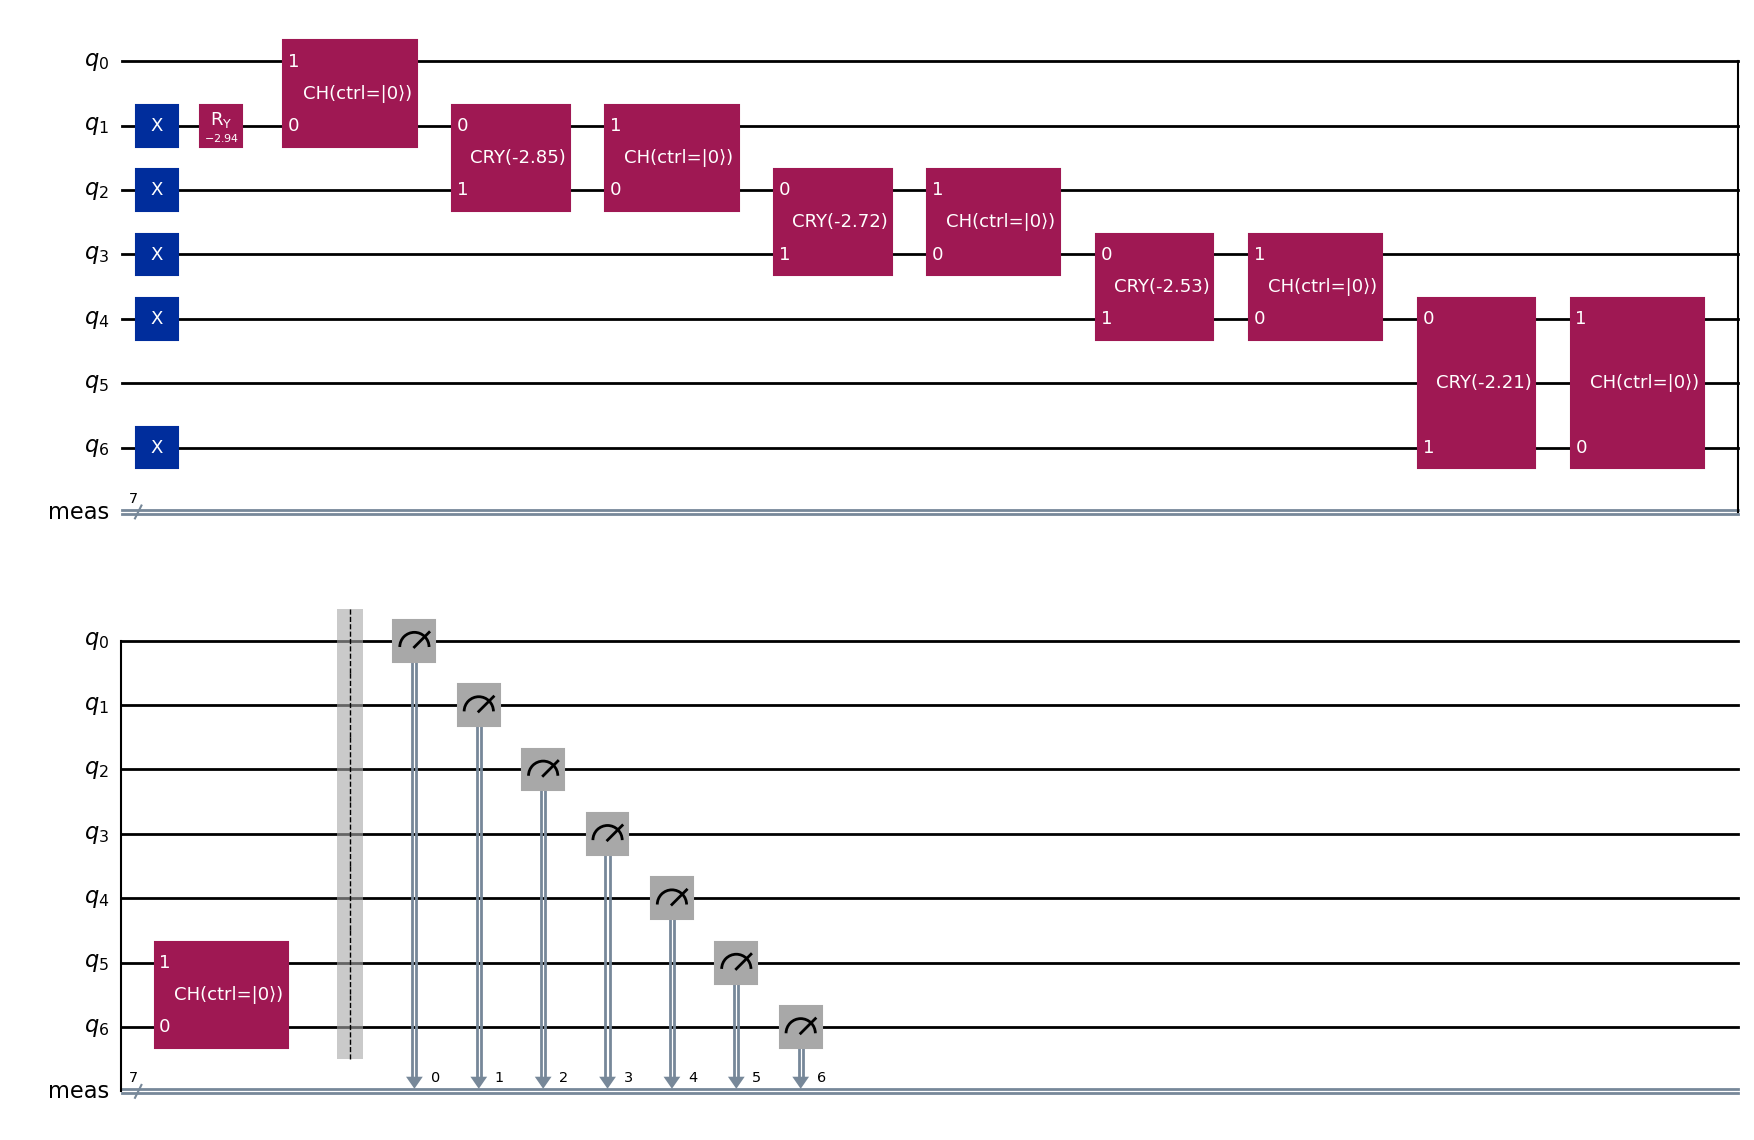

In [4]:
M = 95  # You can change this to any integer
qc = consecutivestates(M)
qc.measure_all()
qc.draw('mpl')  # Draw the circuit


In [5]:
simulator = Aer.get_backend('aer_simulator')
compiled = transpile(qc, simulator)
result = simulator.run(compiled, shots=100000).result()
counts = result.get_counts()

print(f"Measurement counts for M = {M}:")
print(counts)




Measurement counts for M = 95:
{'0111101': 1081, '0100011': 1047, '1001110': 1076, '0001100': 1065, '1010101': 1116, '0011001': 1043, '0000000': 1114, '0110111': 1065, '1000110': 1093, '0111010': 1068, '0100110': 1088, '0001111': 986, '1010011': 1029, '0110011': 984, '0101101': 1080, '0000100': 1093, '1000010': 1032, '0010000': 1076, '0001110': 1054, '1001100': 1042, '0100101': 986, '0111011': 1090, '1010111': 1018, '1011110': 1006, '0000101': 1029, '1000011': 1072, '0101110': 1033, '0110010': 1067, '1010010': 1038, '0010011': 1031, '0101100': 1032, '0110100': 1040, '0000011': 1030, '1000101': 1065, '0100010': 1067, '0111110': 1033, '1001101': 1044, '1010000': 1064, '1001010': 1019, '1000000': 1031, '1000100': 1120, '0110101': 1082, '0101011': 1040, '0100000': 1051, '0010001': 1058, '1011101': 1008, '0101001': 1061, '0011011': 1033, '1001011': 1057, '0100100': 1005, '0111100': 1086, '0010010': 1139, '1010100': 1114, '0011000': 1044, '0010110': 1038, '0001000': 989, '1000111': 1102, '01

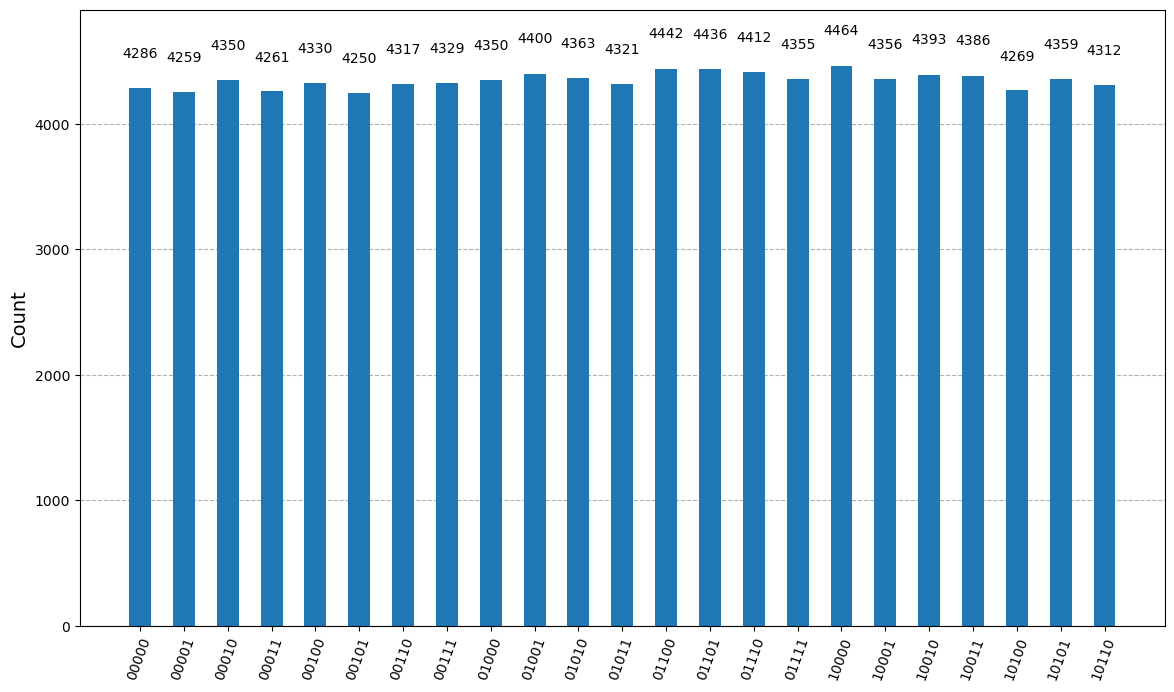

In [42]:
plot_histogram(counts, figsize=(14, 8))
# plt.title(f"Uniform Superposition over {M} States")
# plt.show()